In [14]:
# CAUTION: RUN ONLY IF YOU WISH TO RESET EVERYTHING!
# Dictionaries to hold run data and results:
epidemic_simulators = {}
result_dataframes = {}
objective_dataframes = {}
problems = {}

In [5]:
from policy_epidemic_model_code import *
from jupyterWidgets import *

import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from policy_epidemic_model_code import *
import importlib
import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

import pandas as pd

In [76]:
# Tools for building optimization runs based on params.

class COVID_policy(Problem):

    def __init__(self, model, model_case, lockdown_policy_control_days, lockdown_policy_lower_limits, lockdown_policy_upper_limits, testing_policy_control_days, testing_policy_lower_limits, testing_policy_upper_limits):

        self.model = model
        self.model_case = model_case
        self.lockdown_policy_control_days = lockdown_policy_control_days
        self.testing_policy_control_days = testing_policy_control_days

        super().__init__(n_var=(len(lockdown_policy_control_days)+len(testing_policy_control_days)),
                         n_obj=2,
                         n_constr=0,
                         xl=np.array(lockdown_policy_lower_limits+testing_policy_lower_limits),
                         xu=np.array(lockdown_policy_upper_limits+testing_policy_upper_limits))

    def _evaluate(self, x, out, *args, **kwargs):

        f1 = []
        f2 = []
        f3 = []
        for j in range(len(x[:,1])):  # evaluate f1 and f2 for each individual
            
            # these slices contain indexing for decision variables representing lockdown and testing:
            lockdown_var_slice = slice(0, len(self.lockdown_policy_control_days)+1)
            testing_var_slice = slice(len(self.lockdown_policy_control_days), len(self.lockdown_policy_control_days)+len(self.testing_policy_control_days)+1)
            
            # create policies (dictionaries) for lockdown and testing
            lockdown_policy = create_policy(self.lockdown_policy_control_days, x[j,lockdown_var_slice])
            testing_policy = create_policy(self.testing_policy_control_days, x[j,testing_var_slice])

            Reported_D, Notinfected_D, Unreported_D, Infected_D, False_pos, False_neg, Recovered_D, Dead_D, Infected_T, Infected_not_Q, Infected_in_Q, Y_D, M_t, Y_total, total_cost \
                = self.model.solve_case(self.model_case, lockdown_policy, testing_policy)

            # objectives scaled to roughly same scale
            f1.append(Dead_D[-1]*self.model.pop/1000)
            f2.append(-Y_total/(14*365*self.model.T_years))
            f3.append(total_cost / (Y_total/(14*365*self.model.T_years)) ) # algorithm minimizes total cost per (saved) output unit
            
            #f1.append(Dead_D[-1])
            #f2.append(-Y_total) # algorithm minimizes, Y_total needs to be max'd -> negative


        out["F"] = np.column_stack([f1, f2, f3])
        #out["G"] = np.column_stack([g1, g2])

        
def create_policy(policy_control_times, policy_control_values):
    policy = {} # this will hold the policy in format suitable for input to the epidemic model
    #print("times: ", policy_control_times)
    #print("values: ", policy_control_values)
            
    for (i, t) in enumerate(policy_control_times):
        policy[t] = policy_control_values[i]
        
    return policy

# Run generator

# NOTE: default values for all adjustable run parameters defined in function definition below:
def create_run(ξ_base=0,
    A_rel=0.5, 
    r_AP=0,
    d_vaccine=800,
    rel_ρ=1.0,
    δ_param = 5,
    ωR_param = 14,
    π_D=0.01,
    R_0=2.5,
    rel_λ=0.5, 
    initial_infect=300,
    testing_rate=0.0,
    testing_sensitivity = 1.0,
    testing_specificity = 1.0,
    unknown_q_rate = 0.0,
    recovered_q_rate = 0.0,
    negative_q_rate = 0.0,
    positive_q_rate = 0.999,
    testing_cost=100,
    pop_size=28,
    n_offsprings=14,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=15),
    eliminate_duplicates=True,
    filename = "foo",
    termination = get_termination("n_gen", 100),
    lockdown_policy_control_days = [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    lockdown_policy_lower_limits = list(0.5*np.ones(15)), # can't use len(l_p_c_d) within function param def
    lockdown_policy_upper_limits = list(1.0*np.ones(15)), # needs to be different from lower limit
    testing_policy_control_days = [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    testing_policy_lower_limits = list(np.zeros(14)),
    testing_policy_upper_limits = list(0.2*np.ones(14))
              ):
    
    
    model = optimizable_corona_model(ξ_base, A_rel, r_AP, d_vaccine, rel_ρ, δ_param, \
                 ωR_param, π_D, R_0, rel_λ, initial_infect, testing_cost)
    
    model_case = {
        'τA'            : testing_rate,
        'test_sens'     : testing_sensitivity,
        'test_spec'     : testing_specificity,
        'ξ_U'           : (1+unknown_q_rate)**(1./model.Δ_time)-1,
        'ξ_P'           : (1+positive_q_rate)**(1./model.Δ_time)-1,
        'ξ_N'           : (1+negative_q_rate)**(1./model.Δ_time)-1,
        'ξ_R'           : (1+recovered_q_rate)**(1./model.Δ_time)-1,
        'r_U'           : (1+0.98)**(1./model.Δ_time)-1, # should be redundant!
        'r_P'           : (1+0.98)**(1./model.Δ_time)-1,
        'r_AP'          : 0.0,
        'r_N'           : (1+0.98)**(1./model.Δ_time)-1,
        'r_R'           : (1+0.999)**(1./model.Δ_time)-1,
        'd_start_exp': 0.,
        'experiment': "baseline_vaccine_tag"
    }
    #print("DEBUG policy parameters:")
    #print("ld days:", lockdown_policy_control_days)
    #print("ld lolim: ", lockdown_policy_lower_limits)
    #print("ld hilim:", lockdown_policy_upper_limits)
    #print("t days:", testing_policy_control_days)
    #print("t lolim: ", testing_policy_lower_limits)
    #print("t hilim:", testing_policy_upper_limits)
    
    problem = COVID_policy(model, model_case, lockdown_policy_control_days, lockdown_policy_lower_limits, lockdown_policy_upper_limits, testing_policy_control_days, testing_policy_lower_limits, testing_policy_upper_limits)

    algorithm = NSGA2(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=get_sampling("real_random"),
        crossover=crossover,
        mutation=mutation,
        eliminate_duplicates=True
        )

    
    return problem, algorithm, termination, model, model_case
    




In [20]:
runs = {} # dictionary to hold all runs
### ROMER CASE SCENARIOS ###
#------------------------------------------#

runs['romer']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05]
}

#------------------------------------------#

runs['romer_R0_4.0']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'R_0': 4.0, # set R0 to a higher value
}

#------------------------------------------#

runs['romer_R0_4.0_sens_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75,
    'R_0': 4.0, # set R0 to a higher value
}

#------------------------------------------#

runs['romer_6d_incubation']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'δ_param': 6
}

#------------------------------------------#

runs['romer_8d_incubation']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'δ_param': 8
}

#------------------------------------------#

runs['romer_8d_incubation_sens_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'δ_param': 8,
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75
}
#------------------------------------------#

runs['romer_sens_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75,
}



In [77]:
runs['romer_3d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}

runs['romer_7d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}

runs['romer_14d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}

In [78]:
for run in runs:
    problem, algorithm, termination, model, model_case = create_run(**runs[run])
    epidemic_simulators[run] = (model, model_case)
    problems[run] = problem

In [87]:
runs.keys()

dict_keys(['romer', 'romer_R0_4.0', 'romer_R0_4.0_sens_spec_075', 'romer_6d_incubation', 'romer_8d_incubation', 'romer_8d_incubation_sens_spec_075', 'romer_sens_spec_075', 'romer_3d_delay', 'romer_7d_delay', 'romer_14d_delay'])

In [85]:
lowest_deaths_policy = {}
best_output_policy = {}
lowest_deaths_obj = {}
best_output_obj = {}
best_output_run_data = {}
lowest_deaths_run_data = {}
most_smooth_policy_run_data = {}
most_smooth_policy = {}

for run in runs:
    run_obj_df = pd.read_csv('results/'+run+'_objectives.csv', delimiter=',')
    run_policies_df = pd.read_csv('results/'+run+'_results.csv', delimiter=',')
    run_obj = run_obj_df.to_numpy()
    run_policies = run_policies_df.to_numpy()
    lowest_deaths_policy[run] = run_policies[np.argmin(run_obj[:,0]), :]
    lowest_deaths_obj[run] = run_obj[np.argmin(run_obj[:,0]), :]
    best_output_policy[run] = run_policies[np.argmin(run_obj[:,1]), :] # min because of -1 multiplier
    best_output_obj[run] = run_obj[np.argmin(run_obj[:,1]), :]
    
    best_output_run_ld_policy = create_policy(problem.lockdown_policy_control_days, best_output_policy[run][0:len(problem.lockdown_policy_control_days)])
    print("DEBUG:")
    print("testing days: ", problem.testing_policy_control_days)
    print("testing policy: ", best_output_policy[run][len(problem.lockdown_policy_control_days):len(best_output_policy[run])])
    
    best_output_run_test_policy = create_policy(problem.testing_policy_control_days, best_output_policy[run][len(problem.lockdown_policy_control_days):len(best_output_policy[run])])
    best_output_run_data[run] = epidemic_simulators[run][0].solve_case(epidemic_simulators[run][1], best_output_run_ld_policy, best_output_run_test_policy )
    
    lowest_deaths_run_ld_policy = create_policy(problem.lockdown_policy_control_days, lowest_deaths_policy[run][0:len(problem.lockdown_policy_control_days)])
    lowest_deaths_run_test_policy = create_policy(problem.testing_policy_control_days, lowest_deaths_policy[run][len(problem.lockdown_policy_control_days):len(lowest_deaths_policy[run])])
    lowest_deaths_run_data[run] = epidemic_simulators[run][0].solve_case(epidemic_simulators[run][1], lowest_deaths_run_ld_policy, lowest_deaths_run_test_policy )
    
    # Smoothest policy (least change between consecutive policy steps)
    change_measure = np.zeros(len(run_policies[:,1]))
    for p in range(1,len(run_policies[:,1])):
        for s, v in enumerate(run_policies[p,1:len(run_policies[p,:])]):
            change_measure[p] += abs(v-run_policies[p,s-1])
        #3print("change measure: ", change_measure)
    most_smooth_policy[run] = run_policies[np.argmin(change_measure),:]
    most_smooth_ld_policy = create_policy(problem.lockdown_policy_control_days, most_smooth_policy[run][0:len(problem.lockdown_policy_control_days)])
    most_smooth_test_policy = create_policy(problem.testing_policy_control_days, most_smooth_policy[run][len(problem.lockdown_policy_control_days):len(lowest_deaths_policy[run])])
    most_smooth_policy_run_data[run] = epidemic_simulators[run][0].solve_case(epidemic_simulators[run][1], most_smooth_ld_policy, most_smooth_test_policy )
            

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [4.99634636e-02 1.58905274e-05 1.11253911e-02 1.16011343e-02
 2.71346091e-02 2.36697553e-02 1.94997605e-02 2.02876053e-02
 1.85098269e-02 4.10044805e-02 2.32801708e-02 3.42813476e-02
 4.04007788e-02 1.88660996e-02]
change measure:  [0.         0.21138187 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.21138187 0.17868026 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.21138187 0.17868026 0.18124725 0.         0.
 0.  

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.04997838 0.03311603 0.0137561  0.00022749 0.0262985  0.01230417
 0.01779134 0.01278273 0.01249804 0.02111823 0.03379166 0.01301481
 0.04658633 0.00165911]
change measure:  [0.         0.17036453 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.17036453 0.16899051 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.17036453 0.16899051 0.19883223 0.         0.
 0.         0.         0.         0.         0.         0.
 0.

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [1.21535287e-06 6.25641487e-10 3.47032738e-02 3.57960657e-02
 8.44971650e-03 9.44468359e-03 4.90738474e-02 3.38663647e-02
 1.16310003e-02 3.00252931e-02 3.59334911e-02 2.87380263e-02
 4.86187470e-02 6.72637295e-03]
change measure:  [0.         0.38405593 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.38405593 0.31736694 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.38405593 0.31736694 0.32414722 0.         0.
 0.  

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.04997087 0.00238765 0.01028249 0.00640209 0.03782627 0.00575763
 0.01306194 0.00604244 0.00230805 0.02156463 0.02784969 0.01101329
 0.04725578 0.03529379]
change measure:  [0.         0.23177016 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.23177016 0.32768369 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.23177016 0.32768369 0.3315227  0.         0.
 0.         0.         0.         0.         0.         0.
 0.

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.04999757 0.00246982 0.01313438 0.00877428 0.03085438 0.0140463
 0.04675429 0.01984907 0.01474112 0.02282074 0.02919627 0.01362426
 0.04852991 0.00095019]
change measure:  [0.         0.16479934 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.16479934 0.14022958 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.16479934 0.14022958 0.14549022 0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [8.85761767e-08 1.93272672e-07 3.80083850e-02 4.16787393e-02
 2.94492819e-02 3.52154848e-03 4.52254195e-02 4.51155435e-02
 3.21842782e-03 2.93485982e-02 3.42539820e-02 3.03092893e-02
 4.46419962e-05 5.71661033e-05]
change measure:  [0.         0.26999372 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.26999372 0.35865905 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.26999372 0.35865905 0.3172764  0.         0.
 0.  

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [4.89730973e-06 5.03787393e-09 1.14013828e-02 4.32081541e-02
 4.49411862e-03 9.42686749e-03 4.88920781e-02 6.24290553e-03
 1.45473884e-02 2.12480876e-02 3.27261135e-02 7.23573536e-03
 3.75710351e-03 9.41476709e-03]
change measure:  [0.         0.20357507 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.20357507 0.33512347 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         0.20357507 0.33512347 0.31105811 0.         0.
 0.  

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.2        0.15568722 0.19981076 0.14143066 0.04819969 0.02344872
 0.08588597 0.11328532 0.18204009 0.14595922 0.13140735 0.06262034
 0.08639434 0.12835413 0.16594575]
change measure:  [0.         1.00751437 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         1.00751437 1.17498314 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         1.00751437 1.17498314 1.17804286 0.         0.
 0.         0.         0.         0.         0.    

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.19995392 0.00071389 0.14133369 0.02626128 0.04118816 0.09582136
 0.00742531 0.06976537 0.03928653 0.06982349 0.1453076  0.17936467
 0.08634182 0.08893186 0.16805108]
change measure:  [0.         1.13180356 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         1.13180356 0.87104973 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         1.13180356 0.87104973 1.13557236 0.         0.
 0.         0.         0.         0.         0.    

DEBUG:
testing days:  [15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [1.99939524e-01 1.97143399e-01 3.53407634e-06 3.19893953e-02
 1.53477448e-01 2.78294004e-02 6.37897194e-02 6.86562973e-02
 8.36753739e-02 1.12439722e-02 1.77444839e-01 2.22746968e-02
 1.27076259e-01 1.74027458e-01 4.18296728e-02]
change measure:  [0.         1.46342375 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         1.46342375 0.87567541 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
change measure:  [0.         1.46342375 0.87567541 0.77645467 0.  

In [88]:
lowest_deaths_run_data.keys()

dict_keys(['romer', 'romer_R0_4.0', 'romer_R0_4.0_sens_spec_075', 'romer_6d_incubation', 'romer_8d_incubation', 'romer_8d_incubation_sens_spec_075', 'romer_sens_spec_075', 'romer_3d_delay', 'romer_7d_delay', 'romer_14d_delay'])

In [82]:
time_steps = range(1, len(lowest_deaths_run_data['romer'][2])+1)
time_steps

range(1, 731)

In [83]:
print("most_smooth_policy: ", most_smooth_policy['romer'])
change_measure_ms = 0
for s, v in enumerate(most_smooth_policy['romer'][1:len(most_smooth_policy['romer'])]):
            change_measure_ms += abs(v-most_smooth_policy['romer'][s-1])
print("change measure: ", change_measure_ms)

most_smooth_policy:  [2.50581155e-02 1.00388247e-07 6.43414691e-07 1.29801095e-02
 1.15972097e-02 2.74603443e-02 3.59462123e-02 1.86177483e-02
 1.56391655e-02 1.85082316e-02 6.96657012e-03 3.50184681e-02
 3.49187056e-03 4.07900091e-02 1.88102425e-02]
change measure:  0.18628003054113898


In [45]:
print("lowest deaths policy: ", lowest_deaths_policy['romer'])
change_measure_ms = 0
for s, v in enumerate(lowest_deaths_policy['romer'][1:len(lowest_deaths_policy['romer'])]):
            change_measure_ms += abs(v-lowest_deaths_policy['romer'][s-1])
print("change measure: ", change_measure_ms)

lowest deaths policy:  [2.50461002e-02 4.99634636e-02 1.58905274e-05 1.11253911e-02
 1.16011343e-02 2.71346091e-02 2.36697553e-02 1.94997605e-02
 2.02876053e-02 1.85098269e-02 4.10044805e-02 2.32801708e-02
 3.42813476e-02 4.04007788e-02 1.88660996e-02]
change measure:  0.21138186934112224


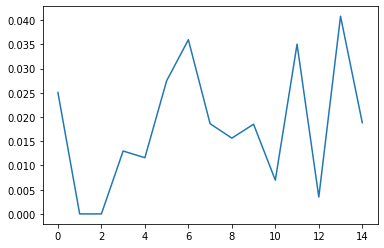

In [30]:
plt.figure()
plt.plot(most_smooth_policy['romer'])

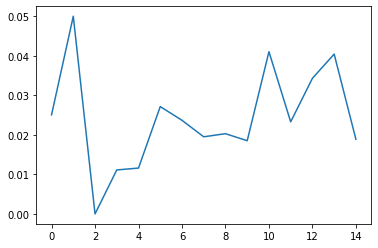

In [31]:
plt.figure()
plt.plot(lowest_deaths_policy['romer'])

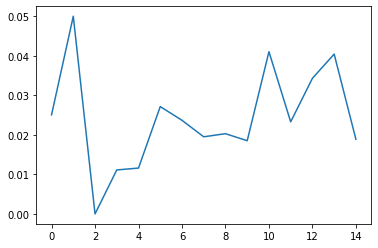

In [33]:
plt.figure()
plt.plot(best_output_policy['romer'])

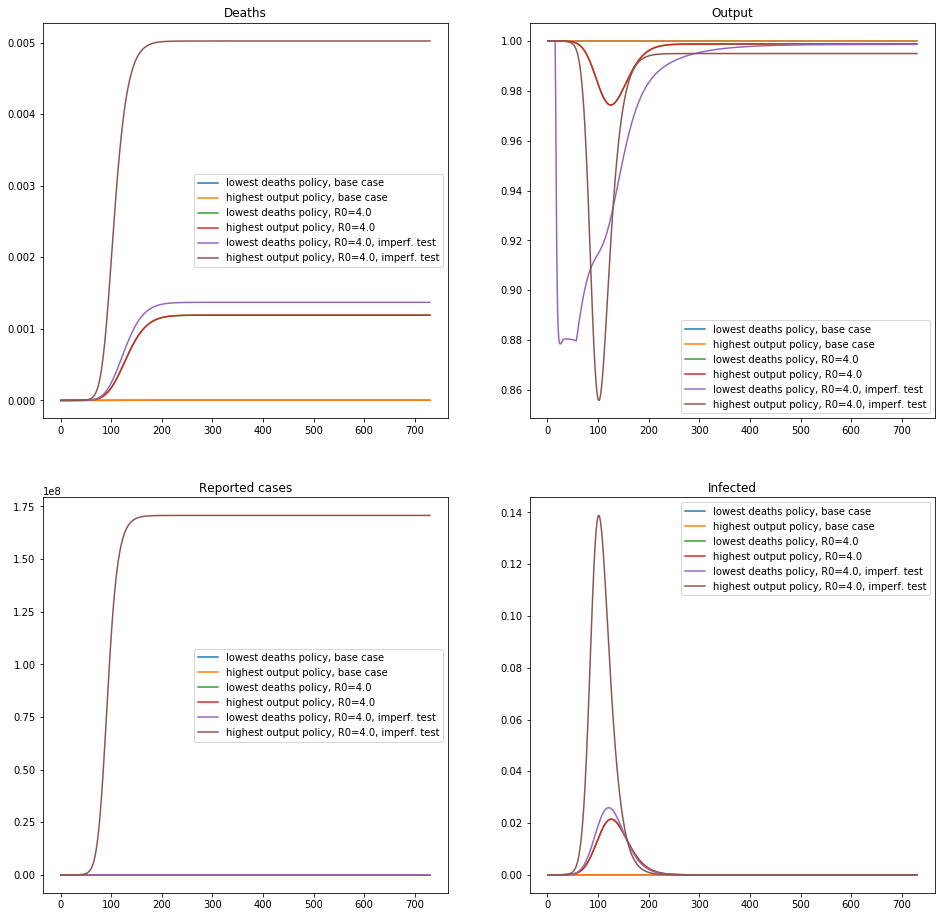

In [46]:
# EFFECTS OF R0 on ROMER CASE

plt.figure(figsize=(16,16))
'romer_R0_4.0_sens_spec_075'
plt.subplot(221)
plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
plt.plot(time_steps, best_output_run_data['romer'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.title("Deaths")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(222)
plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
plt.plot(time_steps, best_output_run_data['romer'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.title("Output")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(223)
plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
plt.plot(time_steps, best_output_run_data['romer'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.title("Reported cases")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(224)
plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
plt.plot(time_steps, best_output_run_data['romer'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.title("Infected")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])


#plt.tight_layout()
plt.show()

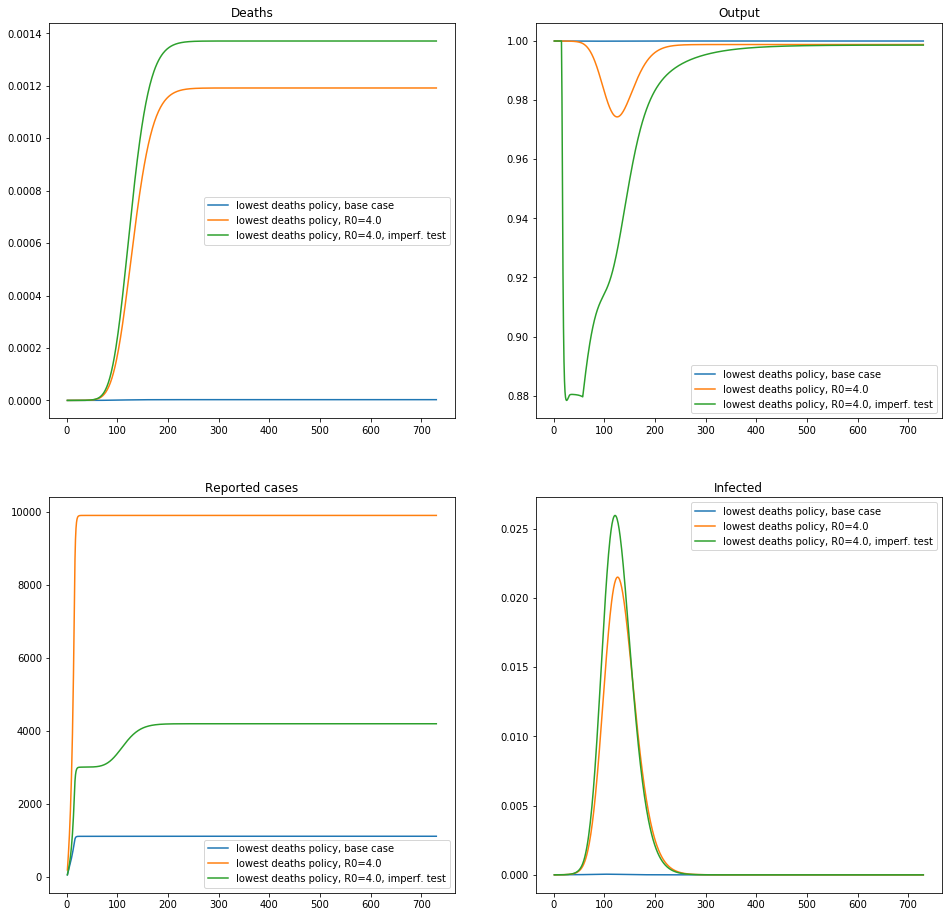

In [49]:
# EFFECTS OF R0 on ROMER CASE

plt.figure(figsize=(16,16))
'romer_R0_4.0_sens_spec_075'
plt.subplot(221)
plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
#plt.plot(time_steps, best_output_run_data['romer'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][7])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][7])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.title("Deaths")
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])

plt.subplot(222)
plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
#plt.plot(time_steps, best_output_run_data['romer'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][11])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][11])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.title("Output")
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])

plt.subplot(223)
plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
#plt.plot(time_steps, best_output_run_data['romer'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][0])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][0])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.title("Reported cases")
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])

plt.subplot(224)
plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
#plt.plot(time_steps, best_output_run_data['romer'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][3])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.title("Infected")
#plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])


#plt.tight_layout()
plt.show()

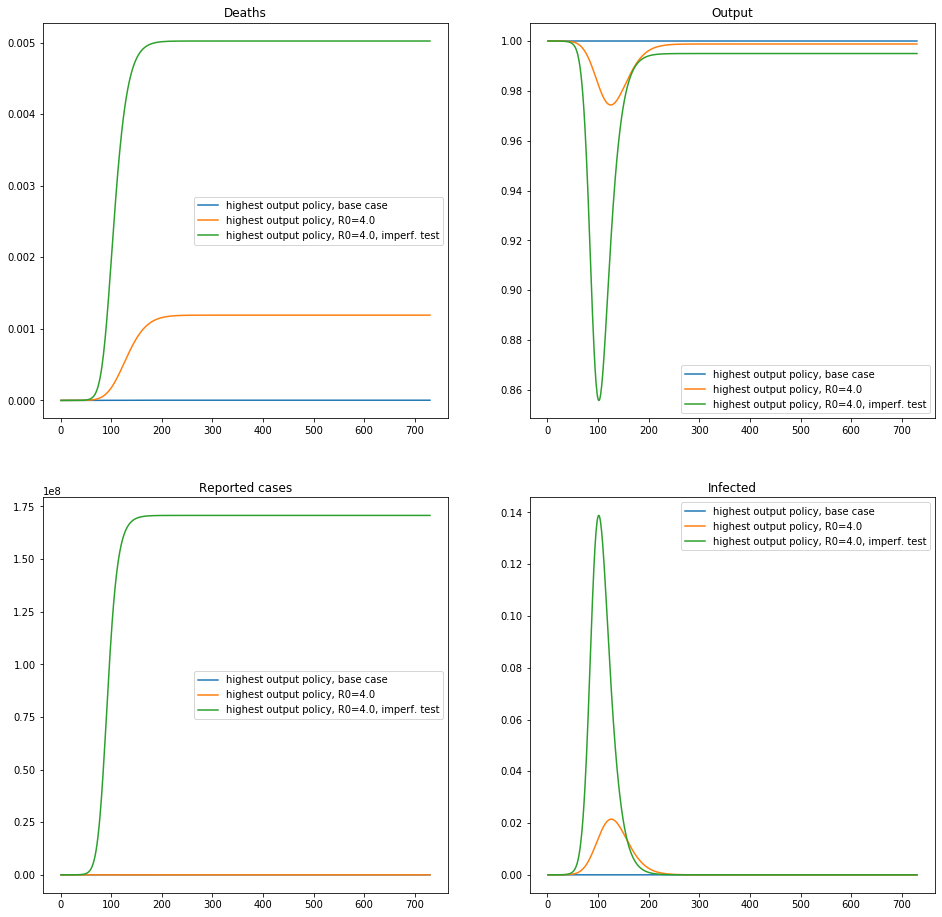

In [50]:
# EFFECTS OF R0 on ROMER CASE

plt.figure(figsize=(16,16))
'romer_R0_4.0_sens_spec_075'
plt.subplot(221)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
plt.plot(time_steps, best_output_run_data['romer'][7])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][7])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.title("Deaths")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(222)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
plt.plot(time_steps, best_output_run_data['romer'][11])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][11])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.title("Output")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(223)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
plt.plot(time_steps, best_output_run_data['romer'][0])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][0])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.title("Reported cases")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(224)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
plt.plot(time_steps, best_output_run_data['romer'][3])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][3])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.title("Infected")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])


#plt.tight_layout()
plt.show()

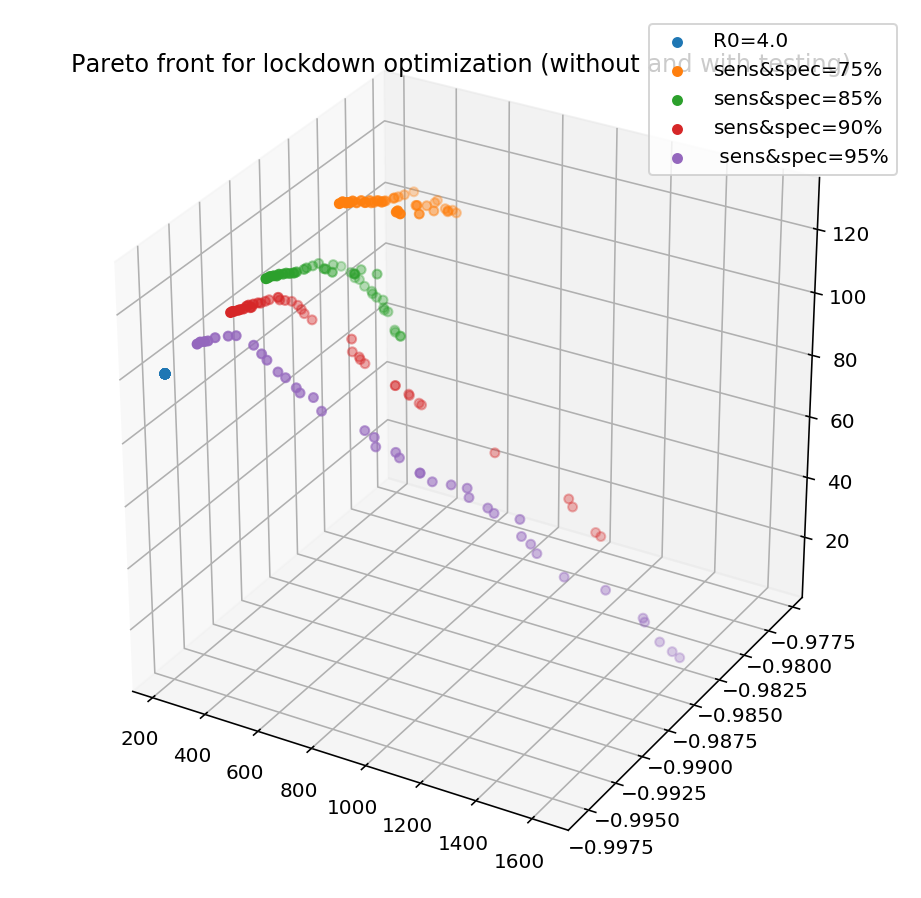

In [22]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk
#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_pt = pd.read_csv('results/romer_R0_4.0_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt75 = pd.read_csv('results/romer_R0_4.0_sens_spec_075_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt85 = pd.read_csv('results/romer_R0_4.0_sens_spec_085_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt90 = pd.read_csv('results/romer_R0_4.0_sens_spec_090_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt95 = pd.read_csv('results/romer_R0_4.0_sens_spec_095_objectives.csv', delimiter=',').to_numpy()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
ax.scatter(run_obj_df_bc_pt[:,0], run_obj_df_bc_pt[:,1], run_obj_df_bc_pt[:,2])
ax.scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,1], run_obj_df_bc_ipt75[:,2])
ax.scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,1], run_obj_df_bc_ipt85[:,2])
ax.scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,1], run_obj_df_bc_ipt90[:,2])
ax.scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,1], run_obj_df_bc_ipt95[:,2])

ax.legend(['R0=4.0', 'sens&spec=75%', 'sens&spec=85%', 'sens&spec=90%',' sens&spec=95%'])
plt.title("Pareto front for lockdown optimization (without and with testing)")
plt.savefig("results/pareto_example.png", dpi=150)



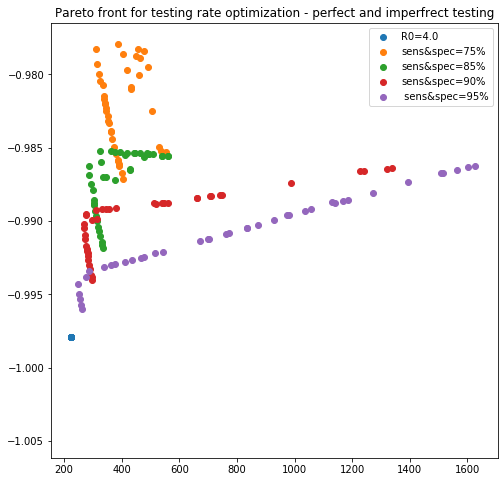

In [23]:
%matplotlib inline
#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_pt = pd.read_csv('results/romer_R0_4.0_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt75 = pd.read_csv('results/romer_R0_4.0_sens_spec_075_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt85 = pd.read_csv('results/romer_R0_4.0_sens_spec_085_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt90 = pd.read_csv('results/romer_R0_4.0_sens_spec_090_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt95 = pd.read_csv('results/romer_R0_4.0_sens_spec_095_objectives.csv', delimiter=',').to_numpy()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
plt.scatter(run_obj_df_bc_pt[:,0], run_obj_df_bc_pt[:,1])
plt.scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,1])
plt.scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,1])
plt.scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,1])
plt.scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,1])

plt.legend(['R0=4.0', 'sens&spec=75%', 'sens&spec=85%', 'sens&spec=90%',' sens&spec=95%'])
plt.title("Pareto front for testing rate optimization - perfect and imperfrect testing")
plt.savefig("results/romer_d_vs_out_pareto_second_version.png", dpi=150)
plt.show()


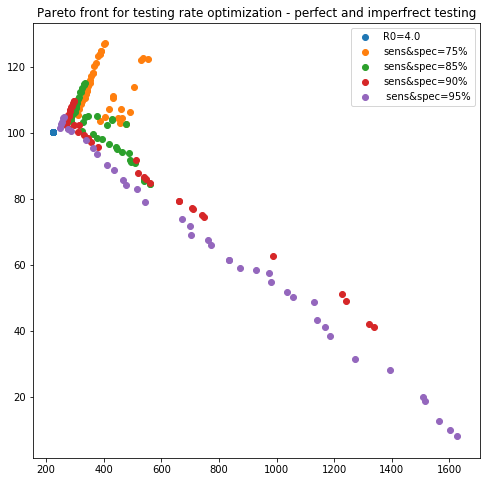

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
ax.scatter(run_obj_df_bc_pt[:,0], run_obj_df_bc_pt[:,2])
ax.scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,2])
ax.scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,2])
ax.scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,2])
ax.scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,2])

ax.legend(['R0=4.0', 'sens&spec=75%', 'sens&spec=85%', 'sens&spec=90%',' sens&spec=95%'])
plt.title("Pareto front for testing rate optimization - perfect and imperfrect testing")
plt.savefig("results/romer_d_vs_cost_pareto_second_version.png", dpi=150)




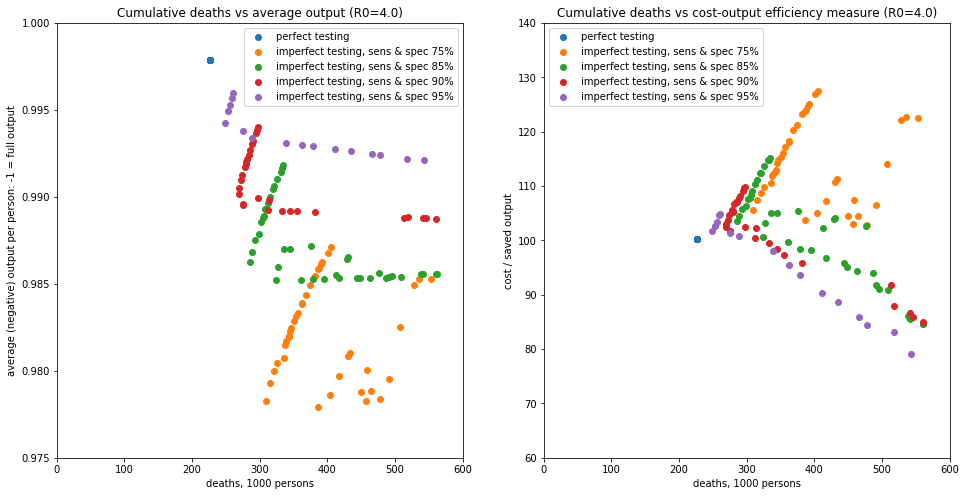

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
axes[0].scatter(run_obj_df_bc_pt[:,0], -1*run_obj_df_bc_pt[:,1], label='perfect testing'),
axes[0].scatter(run_obj_df_bc_ipt75[:,0], -1*run_obj_df_bc_ipt75[:,1], label='imperfect testing, sens & spec 75%')
axes[0].scatter(run_obj_df_bc_ipt85[:,0], -1*run_obj_df_bc_ipt85[:,1], label='imperfect testing, sens & spec 85%')
axes[0].scatter(run_obj_df_bc_ipt90[:,0], -1*run_obj_df_bc_ipt90[:,1], label='imperfect testing, sens & spec 90%')
axes[0].scatter(run_obj_df_bc_ipt95[:,0], -1*run_obj_df_bc_ipt95[:,1], label='imperfect testing, sens & spec 95%')
axes[0].set_title('Cumulative deaths vs average output (R0=4.0)')
axes[0].set_xlabel('deaths, 1000 persons')
axes[0].set_ylabel('average (negative) output per person: -1 = full output')
axes[0].set_xlim(0,600)
axes[0].set_ylim(0.975, 1.00)
axes[0].legend()

axes[1].scatter(run_obj_df_bc_pt[:,0],run_obj_df_bc_pt[:,2], label='perfect testing'),
axes[1].scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,2], label='imperfect testing, sens & spec 75%')
axes[1].scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,2], label='imperfect testing, sens & spec 85%')
axes[1].scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,2], label='imperfect testing, sens & spec 90%')
axes[1].scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,2], label='imperfect testing, sens & spec 95%')
axes[1].set_title('Cumulative deaths vs cost-output efficiency measure (R0=4.0)')
axes[1].set_xlabel('deaths, 1000 persons')
axes[1].set_ylabel('cost / saved output')
axes[1].set_xlim(0,600)
axes[1].set_ylim(60,140)
axes[1].legend()



### Analysis on effects of imperfect testing in Romer case

With perfect testing the optimal solution converges approximately towards a single point. Lowering testing rate could lower costs, but at the same time this would risk more deaths and lower the saved output. On the other hand, with a certain profile, the more testing will do little good, but would generate more costs. 

With imperfect testing, more tests will lead to false positives and false negatives, which will then create tradeoffs. A great number of false positives will lead to reduced output. Thus, increasing testing in a low infectious population situation, will lower deaths but increase the number of people in quarantine without good reason. However, when the population contains many infected persons, the benefits are clear.

How low deaths can be pushed just by testing is dependent on the true positive rate, i.e. sensitivity. If the test has <1.0 sensitivity, some subjects will always gett false negative results, and end up spreading the disease without anybody knowing about it.

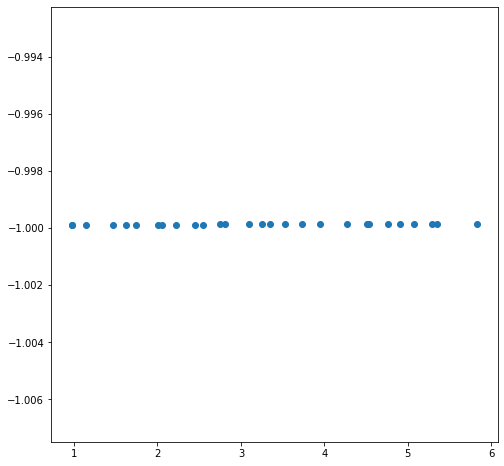

In [90]:
plt.figure(figsize=(8,8))
plt.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1])

### Effects of delay between infection and symptoms:

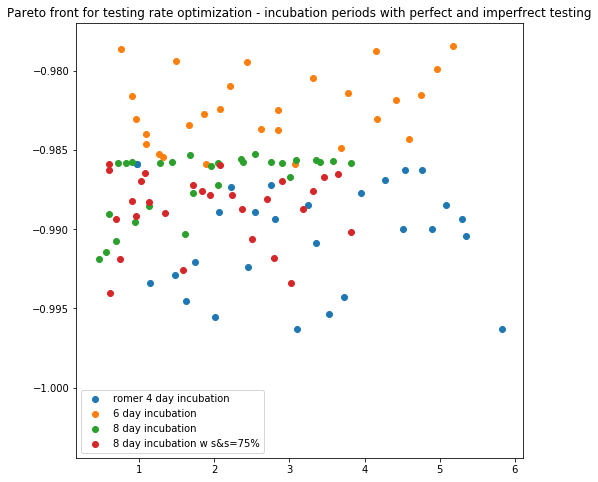

In [119]:

#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_6incu = pd.read_csv('results/romer_6d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu = pd.read_csv('results/romer_8d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu_ss75 = pd.read_csv('results/romer_8d_incubation_sens_spec_075_objectives.csv', delimiter=',').to_numpy()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
plt.scatter(run_obj_df_romer[:,0], run_obj_df_bc_pt[:,1])
plt.scatter(run_obj_df_romer_6incu[:,0], run_obj_df_bc_ipt75[:,1])
plt.scatter(run_obj_df_romer_8incu[:,0], run_obj_df_bc_ipt85[:,1])
plt.scatter(run_obj_df_romer_8incu_ss75[:,0], run_obj_df_bc_ipt90[:,1])

plt.legend(['romer 4 day incubation', '6 day incubation', '8 day incubation', '8 day incubation w s&s=75%'])
plt.title("Pareto front for testing rate optimization - incubation periods with perfect and imperfrect testing")
plt.savefig("results/romer_incubation_pareto.png", dpi=150)
plt.show()


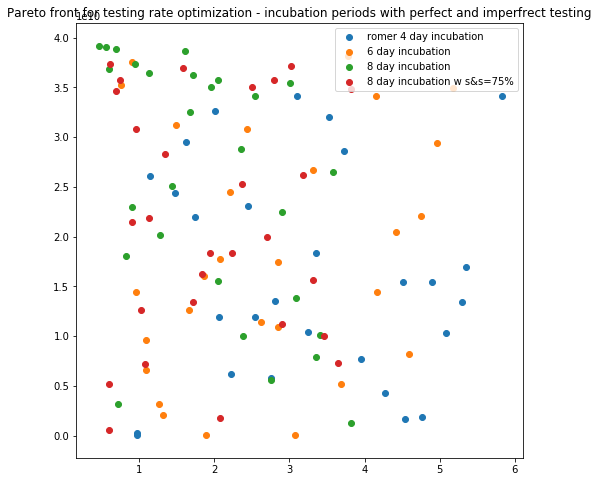

In [120]:

#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_6incu = pd.read_csv('results/romer_6d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu = pd.read_csv('results/romer_8d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu_ss75 = pd.read_csv('results/romer_8d_incubation_sens_spec_075_objectives.csv', delimiter=',').to_numpy()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
plt.scatter(run_obj_df_romer[:,0], run_obj_df_bc_pt[:,2])
plt.scatter(run_obj_df_romer_6incu[:,0], run_obj_df_bc_ipt75[:,2])
plt.scatter(run_obj_df_romer_8incu[:,0], run_obj_df_bc_ipt85[:,2])
plt.scatter(run_obj_df_romer_8incu_ss75[:,0], run_obj_df_bc_ipt90[:,2])

plt.legend(['romer 4 day incubation', '6 day incubation', '8 day incubation', '8 day incubation w s&s=75%'])
plt.title("Pareto front for testing rate optimization - incubation periods with perfect and imperfrect testing")
plt.savefig("results/romer_incubation_pareto_d_vs_cost.png", dpi=150)
plt.show()


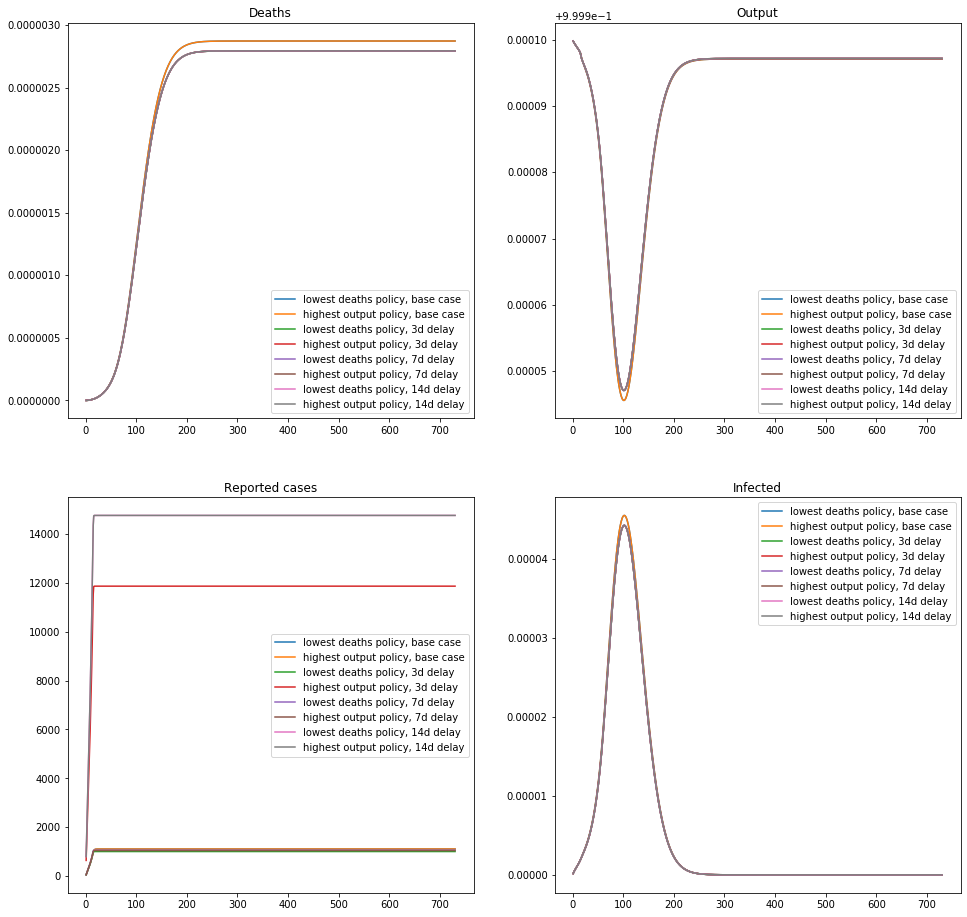

In [89]:
# EFFECTS OF DELAY on ROMER CASE

plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
plt.plot(time_steps, best_output_run_data['romer'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][7])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][7])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][7])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][7])
plt.title("Deaths")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])

plt.subplot(222)
plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
plt.plot(time_steps, best_output_run_data['romer'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][11])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][11])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][11])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][11])
plt.title("Output")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])

plt.subplot(223)
plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
plt.plot(time_steps, best_output_run_data['romer'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][0])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][0])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][0])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][0])
plt.title("Reported cases")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])

plt.subplot(224)
plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
plt.plot(time_steps, best_output_run_data['romer'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][3])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][3])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][3])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][3])
plt.title("Infected")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])


#plt.tight_layout()
plt.show()

In [81]:
lowest_deaths_run_data

{'romer': (array([  54.12240319,  109.90625729,  164.2530567 ,  218.1372533 ,
          272.39296147,  327.75119446,  384.8650375 ,  444.32927901,
          506.69644801,  572.49014572,  642.21624939,  716.3724292 ,
          795.45633183,  879.97271876,  970.43979501, 1037.65030384,
         1072.5979211 , 1090.52353088, 1099.6308914 , 1104.23757249,
         1106.56558609, 1107.74319864, 1108.33992075, 1108.6428582 ,
         1108.79691183, 1108.87536458, 1108.91536237, 1108.93577239,
         1108.94619407, 1108.95151817, 1108.95543619, 1108.95953258,
         1108.96381798, 1108.96830311, 1108.97299889, 1108.97791651,
         1108.9830675 , 1108.98846378, 1108.99411769, 1109.00004208,
         1109.00625034, 1109.0127564 , 1109.01957485, 1109.02672091,
         1109.03421051, 1109.04206031, 1109.05028775, 1109.05891109,
         1109.06794948, 1109.07742293, 1109.08735246, 1109.09776004,
         1109.10866874, 1109.1201027 , 1109.13208723, 1109.14464887,
         1109.15781541, 1